In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math
from scipy.integrate import solve_ivp
from numpy import cos
from math import log

In [2]:
from sage.calculus.desolvers import desolve_system_rk4

Utilizando dados de Manaus e Vivax:

T1: 27.4

R1: 196.9

Tmin: 14.5

N: 8557

In [3]:
# Dados originais do artigo Modelling Climate Change and Malaria Transmission de Parham & Michael

# Definindo as constantes
num_steps = 50 # Tempo total
dt = 1 # Tamanho do passo

T1 = 23.2  # Temperatura média na ausência de sazonalidade (˚C)
T2 = 0.07  # Amplitude da variabilidade sazonal na temperatura
omega1 = 0.67  # Frequência angular das oscilações sazonais na temperatura (meses^–1)
phi1 = 1.53  # "Phase lag" da variabilidade da temperatura (defasagem de fase)
R1 = 85.9  # Precipitação mensal média na ausência de sazonalidade (mm)
R2 = 0.98  # Amplitude da variabilidade sazonal na precipitação
omega2 = 0.65  # Frequência angular das oscilações sazonais na precipitação (meses^–1)
phi2 = 1.99  # "Phase lag" da variabilidade da precipitação (defasagem de fase)

B_E = 200 # Número de ovos colocados por adulto por oviposição
p_ME = 0.9 # Probabilidade de sobrevivência dos ovos
p_ML = 0.25 # Probabilidade de sobrevivência das larvas
p_MP = 0.75 # Probabilidade de sobrevivência dos pupas
tau_E = 1 # Duração da fase de desenvolvimento dos ovos
tau_P = 1 # Duração da fase de desenvolvimento das pupas
c1 = 0.00554 # Constante (˚C dias)^-1
c2 = -0.06737 # Constante (dias)^-1

D1 = 36.5 # Valor fixo
b1 = 0.04 # Proporção de picadas de mosquitos suscetíveis em humanos infectados que resultam em infecção
A = -0.03 # Constante (˚C^2 dias)^-1
B = 1.31 # Constante (˚C dias)^-1
C = -4.4 # Constante (dias)^-1
b2 = 0.09 # Proporção de picadas de mosquitos infectados em humanos suscetíveis que resultam em infecção
tau_H = 10 # Período latente de infecção em humanos
DD = 111 # "Degree days" para desenvolvimento do parasita
Tmin = 16 # Temperatura mínima (abaixo dessa temperatura não há desenvolvimento do parasita)
gamma = 1/120 # 1/Duração média da infecciosidade humana em dias
R_L = 50 # Chuva limite até que os sítios de reprodução sejam eliminados, removendo indivíduos de estágio imaturo

N = 1000  # Número total de humanos
M = 10000  # Número total de mosquitos
I_M0 = M  # Número inicial de mosquitos infectados
I_H0 = 10  # Número inicial de humanos infectados
S_H0 = N - I_H0 # Número inicial de pessoas suscetíveis

R_0: 0.0005233502900837928
Prevalência de equilíbrio para mosquitos: 47087.833535792284
Prevalência de equilíbrio para humanos: 1541426.3318917223


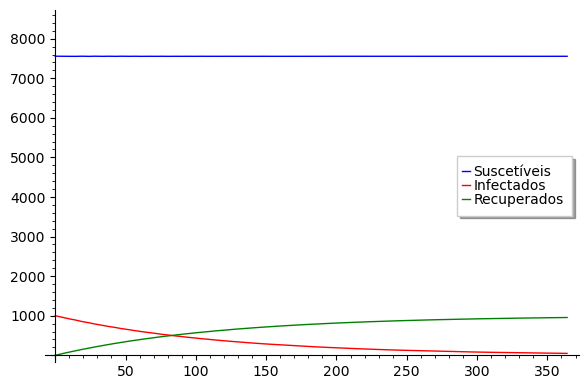

In [4]:
def run_simulation(num_steps=365, dt=1, T1=27.4, T2=0.025, omega1=0.67, phi1=1.53, R1=196.9, R2=-0.033, omega2=0.65, phi2=1.99,
                   B_E=200, p_ME=0.9, p_ML=0.25, p_MP=0.75, tau_E=1, tau_P=1, c1=0.00554, c2=-0.06737,
                   D1=36.5, b1=0.04, A=-0.03, B=1.31, C=-4.4, b2=0.09, tau_H=10, DD=105, Tmin=14.5, gamma=1/120, R_L = 50,
                   N=8557, M=10000, I_M0=None, I_H0=1000):
    
    # Definindo as constantes
    if I_M0 is None:
        I_M0 = M / 100

    S_H0 = N - I_H0

    # Funções de temperatura e chuva
    def T(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def R(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    # Duração da fase de desenvolvimento das larvas
    def tau_L(T):
        return 1 / (c1 * T + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(T):
        return np.exp(-1 / (A*T**2 + B*T + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(T):
        return np.exp(-(c1 * T + c2))
    
    def p_LR(R):
        return (4*p_ML/R_L**2) * R * (R_L - R)
    
    def p_LRT(R,T):
        return p_LR(R)*p_LT(T)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(R):
        return (4*p_ME/R_L**2) * R * (R_L - R)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(R):
        return (4*p_MP/R_L**2) * R * (R_L - R)

    # Duração do ciclo esporogônico
    def tau_M(T):
        return DD / (T - Tmin)

    # Definindo a função de sobrevivência do mosquito
    def l(tau_M, T):  
        p_T = p(T)
        return p_T**tau_M

    # Definindo a taxa de mortalidade do mosquito
    def mu(T):
        return -log(p(T))

    # Simulando as equações diferenciais
    S_H = [S_H0]
    I_H = [I_H0]
    R_H = [0]
    times = [0]

    for t in range(1, num_steps):
        # Atualiza a temperatura e a chuva
        T_curr = T(t * dt)
        R_curr = R(t * dt)

        # Calcular a taxa de mordida e probabilidade de transmissão
        a = (T_curr - T1) / D1
        b = B_E * p_ME * p_LRT(R_curr,T_curr) * p_MP / (tau_E + tau_L(T_curr) + tau_P)
        #print(b)
        
        # b = B_E * p_E(R_curr) * p_LRT(R_curr,T_curr) * p_P(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
        # p_E(R), p_P(R) = ?
        
        if t < tau_H:
            dS_H = -a * b2 * (I_M0 / N) * S_H[-1]
            dI_H = a * b2 * (I_M0 / N) * S_H[-1] - gamma * I_H[-1]
        else:
            dS_H = -a * b2 * (I_H[t - tau_H] / N) * S_H[t - tau_H]
            dI_H = a * b2 * (I_H[t - tau_H] / N) * S_H[t - tau_H] - gamma * I_H[-1]
        dR_H = gamma * I_H[-1]

        # Atualize as populações
        S_H.append(S_H[-1] + dt * dS_H)
        I_H.append(I_H[-1] + dt * dI_H)
        R_H.append(R_H[-1] + dt * dR_H)
        times.append(t * dt)

    # Calculando R_0
    def calculate_R0(M, a, b1, b2, T, gamma, N): # , mu)
        tau_M_T = tau_M(T)
        l_tau_M = l(tau_M_T, T)  
        R_0 = (M * a**2 * b1 * b2 * l_tau_M) / (gamma * mu(T) * N)
        return R_0

    R_0 = calculate_R0(M, a, b1, b2, T1, gamma, N)  # , mu)
    print(f"R_0: {R_0}")

    # Calcular prevalências de equilíbrio
    I_M_star = M * (R_0 - 1) / ((R_0 / l(DD / (T1 - Tmin), T1)) + (a * b2 * M / (gamma * N)))
    I_H_star = N * (R_0 - 1) / (R_0 + (a * b1 / mu(T1)))

    print(f"Prevalência de equilíbrio para mosquitos: {I_M_star}")
    print(f"Prevalência de equilíbrio para humanos: {I_H_star}")

    times = [i*dt for i in range(num_steps)]

    # Criar os gráficos
    p1 = line(zip(times, S_H), color='blue', legend_label='Suscetíveis')
    p2 = line(zip(times, I_H), color='red', legend_label='Infectados')
    p3 = line(zip(times, R_H), color='green', legend_label='Recuperados')

    # Combinar os gráficos e mostrar o resultado
    (p1 + p2 + p3).show(xmin=0, xmax=num_steps*dt, ymin=0, ymax=N)

# Executar a simulação com os parâmetros padrão
run_simulation()

R_0: 0.013265476102818355
Prevalência de equilíbrio para mosquitos: 4627.473574037336
Prevalência de equilíbrio para humanos: 4411398.21832882


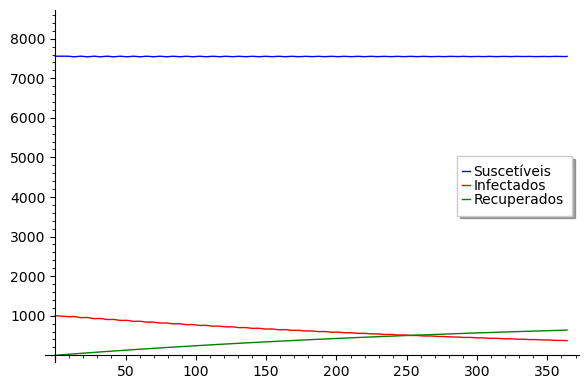

In [5]:
run_simulation(num_steps=365, dt=1, T1=27.4, T2=0.025, omega1=0.67, phi1=1.53, R1=196.9, R2=-0.033, omega2=0.65, phi2=1.99,
                   B_E=200, p_ME=0.9, p_ML=0.25, p_MP=0.75, tau_E=1, tau_P=1, c1=0.00554, c2=-0.06737,
                   D1=36.5, b1=0.1, A=-0.03, B=1.31, C=-4.4, b2=0.3, tau_H=10, DD=105, Tmin=14.5, gamma=1/365, R_L = 50,
                   N=8557, M=10000, I_M0=None, I_H0=1000)

R_0: 0.0005233502900837928
Prevalência de equilíbrio para mosquitos: 47087.833535792284
Prevalência de equilíbrio para humanos: 1541426.3318917223


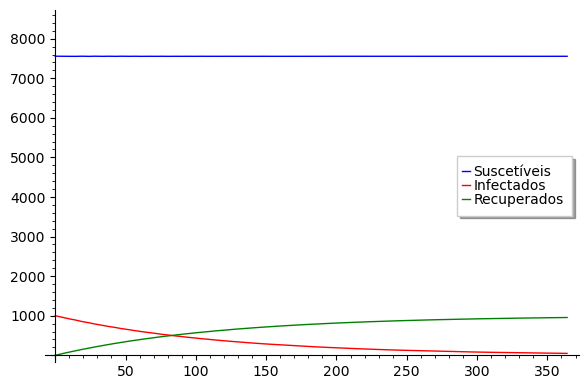

In [6]:
def run_simulation(num_steps=365, dt=1, T1=27.4, T2=0.025, omega1=0.67, phi1=1.53, R1=196.9, R2=-0.033, omega2=0.65, phi2=1.99,
                   B_E=200, p_ME=0.9, p_ML=0.25, p_MP=0.75, tau_E=1, tau_P=1, c1=0.00554, c2=-0.06737,
                   D1=36.5, b1=0.04, A=-0.03, B=1.31, C=-4.4, b2=0.09, tau_H=10, DD=105, Tmin=14.5, gamma=1/120, R_L = 50,
                   N=8557, M=10000, I_M0=None, I_H0=1000):
    
    # Definindo as constantes
    if I_M0 is None:
        I_M0 = M / 100

    S_H0 = N - I_H0

    # Funções de temperatura e chuva
    def T(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def R(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    # Duração da fase de desenvolvimento das larvas
    def tau_L(T):
        return 1 / (c1 * T + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(T):
        return np.exp(-1 / (A*T**2 + B*T + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(T):
        return np.exp(-(c1 * T + c2))
    
    def p_LR(R):
        return (4*p_ML/R_L**2) * R * (R_L - R)
    
    def p_LRT(R,T):
        return p_LR(R)*p_LT(T)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_E(R):
        return (4*p_ME/R_L**2) * R * (R_L - R)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_P(R):
        return (4*p_MP/R_L**2) * R * (R_L - R)

    # Duração do ciclo esporogônico
    def tau_M(T):
        return DD / (T - Tmin)

    # Definindo a função de sobrevivência do mosquito
    def l(tau_M, T):  
        p_T = p(T)
        return p_T**tau_M

    # Definindo a taxa de mortalidade do mosquito
    def mu(T):
        return -log(p(T))

    # Simulando as equações diferenciais
    S_H = [S_H0]
    I_H = [I_H0]
    R_H = [0]
    times = [0]

    for t in range(1, num_steps):
        # Atualiza a temperatura e a chuva
        T_curr = T(t * dt)
        R_curr = R(t * dt)

        # Calcular a taxa de mordida e probabilidade de transmissão
        a = (T_curr - T1) / D1
        #b = B_E * p_ME * p_LRT(R_curr,T_curr) * p_MP / (tau_E + tau_L(T_curr) + tau_P)
        
        b = B_E * p_E(R_curr) * p_LRT(R_curr,T_curr) * p_P(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
        #print(b)
        
        if t < tau_H:
            dS_H = -a * b2 * (I_M0 / N) * S_H[-1]
            dI_H = a * b2 * (I_M0 / N) * S_H[-1] - gamma * I_H[-1]
        else:
            dS_H = -a * b2 * (I_H[t - tau_H] / N) * S_H[t - tau_H]
            dI_H = a * b2 * (I_H[t - tau_H] / N) * S_H[t - tau_H] - gamma * I_H[-1]
        dR_H = gamma * I_H[-1]

        # Atualize as populações
        S_H.append(S_H[-1] + dt * dS_H)
        I_H.append(I_H[-1] + dt * dI_H)
        R_H.append(R_H[-1] + dt * dR_H)
        times.append(t * dt)

    # Calculando R_0
    def calculate_R0(M, a, b1, b2, T, gamma, N): # , mu)
        tau_M_T = tau_M(T)
        l_tau_M = l(tau_M_T, T)  
        R_0 = (M * a**2 * b1 * b2 * l_tau_M) / (gamma * mu(T) * N)
        return R_0

    R_0 = calculate_R0(M, a, b1, b2, T1, gamma, N)  # , mu)
    print(f"R_0: {R_0}")

    # Calcular prevalências de equilíbrio
    I_M_star = M * (R_0 - 1) / ((R_0 / l(DD / (T1 - Tmin), T1)) + (a * b2 * M / (gamma * N)))
    I_H_star = N * (R_0 - 1) / (R_0 + (a * b1 / mu(T1)))

    print(f"Prevalência de equilíbrio para mosquitos: {I_M_star}")
    print(f"Prevalência de equilíbrio para humanos: {I_H_star}")

    times = [i*dt for i in range(num_steps)]

    # Criar os gráficos
    p1 = line(zip(times, S_H), color='blue', legend_label='Suscetíveis')
    p2 = line(zip(times, I_H), color='red', legend_label='Infectados')
    p3 = line(zip(times, R_H), color='green', legend_label='Recuperados')

    # Combinar os gráficos e mostrar o resultado
    (p1 + p2 + p3).show(xmin=0, xmax=num_steps*dt, ymin=0, ymax=N)

# Executar a simulação com os parâmetros padrão
run_simulation()

In [7]:
# Inicializando os parâmetros
num_steps = 365
dt = 1
t_initial = 0
t_final = num_steps * dt
T1 = 27.4
T2 = 0.025
omega1 = 0.67
phi1 = 1.53
R1 = 196.9
R2 = -0.033
omega2 = 0.65
phi2 = 1.99
B_E = 200
p_ME = 0.9
p_ML = 0.25
p_MP = 0.75
tau_E = 1
tau_P = 1
c1 = 0.00554
c2 = -0.06737
D1 = 36.5
b1 = 0.04
A = -0.03
B = 1.31
C = -4.4
b2 = 0.09
tau_H = 10
DD = 105
Tmin = 14.5
gamma = 1/120
R_L = 50
N = 8558
M = 10000
I_M0 = 5000 # None
I_H0 = 1000
if I_M0 is None:
        I_M0 = M / 100
S_H0 = N - I_H0

In [8]:
# Definindo funções auxiliares
def Temp(t):
    return T1 * (1 + T2 * cos(omega1 * t - phi1))

def Rain(t):
    return R1 * (1 + R2 * cos(omega2 * t - phi2))

def tau_L(Temp):
    return 1 / (c1 * Temp + c2)

def p(Temp):
    return np.exp(-1 / (A*Temp**2 + B*Temp + C))

def p_LT(Temp):
    return np.exp(-(c1 * Temp + c2))

def p_LR(Rain):
    return (4*p_ML/R_L**2) * Rain * (R_L - Rain)

def p_LRT(Rain,Temp):
    return p_LR(Rain)*p_LT(Temp)

def tau_M(Temp):
    return DD / (Temp - Tmin)

def l(tau_M, Temp):  
    p_T = p(Temp)
    return p_T**tau_M

def mu(Temp):
    return -np.log(p(Temp))

In [9]:
# Definindo a função do sistema de equações diferenciais
def diff(t, Y):
    S_H, I_H, R_H = Y
    T_curr = Temp(t)
    R_curr = Rain(t)
    tau_M_T = tau_M(T_curr)
    l_tau_M = l(tau_M_T, T_curr)
    a = (T_curr - T1) / D1
    b = B_E * p_ME * p_LRT(R_curr, T_curr) * p_MP / (tau_E + tau_L(T_curr) + tau_P)

    if t < tau_H:
        dS_H = -a * b2 * (I_M0 / N) * S_H
        dI_H = a * b2 * (I_M0 / N) * S_H - gamma * I_H
    else:
        dS_H = -a * b2 * (I_H / N) * S_H
        dI_H = a * b2 * (I_H / N) * S_H - gamma * I_H
    dR_H = gamma * I_H

    return [dS_H, dI_H, dR_H]

In [10]:
# Solucionando o sistema de equações diferenciais
sol = solve_ivp(diff, [t_initial, t_final], [S_H0, I_H0, 0], t_eval=np.linspace(t_initial, t_final, num_steps))

In [11]:
# Extraindo as soluções
times = sol.t
S_H, I_H, R_H = sol.y

In [12]:
times

array([  0.        ,   1.00274725,   2.00549451,   3.00824176,
         4.01098901,   5.01373626,   6.01648352,   7.01923077,
         8.02197802,   9.02472527,  10.02747253,  11.03021978,
        12.03296703,  13.03571429,  14.03846154,  15.04120879,
        16.04395604,  17.0467033 ,  18.04945055,  19.0521978 ,
        20.05494505,  21.05769231,  22.06043956,  23.06318681,
        24.06593407,  25.06868132,  26.07142857,  27.07417582,
        28.07692308,  29.07967033,  30.08241758,  31.08516484,
        32.08791209,  33.09065934,  34.09340659,  35.09615385,
        36.0989011 ,  37.10164835,  38.1043956 ,  39.10714286,
        40.10989011,  41.11263736,  42.11538462,  43.11813187,
        44.12087912,  45.12362637,  46.12637363,  47.12912088,
        48.13186813,  49.13461538,  50.13736264,  51.14010989,
        52.14285714,  53.1456044 ,  54.14835165,  55.1510989 ,
        56.15384615,  57.15659341,  58.15934066,  59.16208791,
        60.16483516,  61.16758242,  62.17032967,  63.17

In [13]:
S_H, I_H, R_H

(array([7558.        , 7555.30041575, 7548.94299274, 7541.67081969,
        7536.66829233, 7535.8513207 , 7539.54329438, 7546.47508244,
        7553.78503346, 7557.72876088, 7558.52908797, 7557.68699458,
        7556.32084095, 7555.22150943, 7554.85240445, 7555.34945249,
        7556.52110215, 7557.84784019, 7558.25313645, 7557.60231086,
        7556.38437436, 7554.99661471, 7553.74459649, 7552.84216112,
        7552.41142681, 7552.48278862, 7552.99491841, 7553.7947649 ,
        7554.63755358, 7555.18678682, 7555.01424376, 7554.14370499,
        7554.00082693, 7554.49204348, 7555.40529965, 7556.55819694,
        7557.7979934 , 7559.00160355, 7560.07559846, 7560.95620568,
        7561.60930931, 7562.03044993, 7562.24482466, 7562.30728711,
        7562.30234741, 7562.34417222, 7562.57658469, 7563.03099589,
        7563.53451717, 7564.00715402, 7564.38457161, 7564.6174112 ,
        7564.67129008, 7564.52680163, 7564.17951528, 7563.63997654,
        7562.93370699, 7562.10120426, 7561.19794

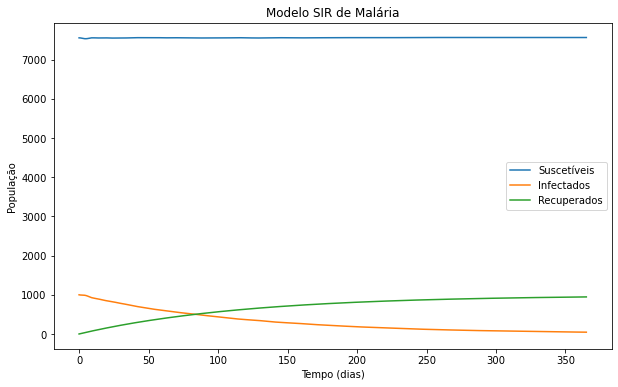

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [15]:
# Inicializando os parâmetros
num_steps = 365
dt = 1
t_initial = 0
t_final = num_steps * dt

T1=27.4
T2=0.025
omega1=0.02
phi1=1.53

R1=196.9
R2=0.033
omega2=0.025
phi2=1.99

B_E=200
p_ME=0.9
p_ML=0.25
p_MP=0.75
tau_E=1
tau_P=1
c1=0.00554
c2=-0.06737
D1=36.5
b1=0.1
A=-0.03
B=1.31
C=-4.4
b2=0.3
tau_H=10
DD=105
Tmin=14.5
gamma= 1/1095 #1/365
R_L = 50
N=8558
M= 300000 #100000
I_M0=50000 # None
I_H0=1000 
if I_M0 is None:
        I_M0 = M / 100

S_H0 = N - I_H0

# Definindo a função do sistema de equações diferenciais
def diff(t, Y):
    S_H, I_H, R_H = Y
    T_curr = Temp(t)
    R_curr = Rain(t)
    tau_M_T = tau_M(T_curr)
    l_tau_M = l(tau_M_T, T_curr)
    a = (T_curr - T1) / D1
    b = B_E * p_ME * p_LRT(R_curr, T_curr) * p_MP / (tau_E + tau_L(T_curr) + tau_P)

    if t < tau_H:
        dS_H = -a * b2 * (I_M0 / N) * S_H
        dI_H = a * b2 * (I_M0 / N) * S_H - gamma * I_H
    else:
        dS_H = -a * b2 * (I_H / N) * S_H
        dI_H = a * b2 * (I_H / N) * S_H - gamma * I_H
    dR_H = gamma * I_H

    return [dS_H, dI_H, dR_H]

In [16]:
# Solucionando o sistema de equações diferenciais
sol = solve_ivp(diff, [t_initial, t_final], [S_H0, I_H0, 0], t_eval=np.linspace(t_initial, t_final, num_steps))

# Extraindo as soluções
times = sol.t
S_H, I_H, R_H = sol.y

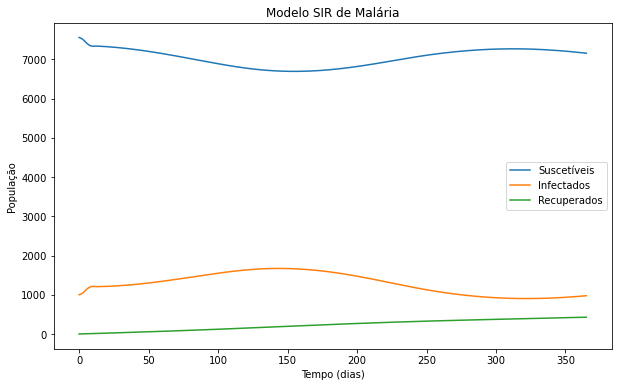

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

R_0: 1.0891733303171252
Prevalência de equilíbrio para mosquitos: 141.68445976121222
Prevalência de equilíbrio para humanos: 691.4598653676074


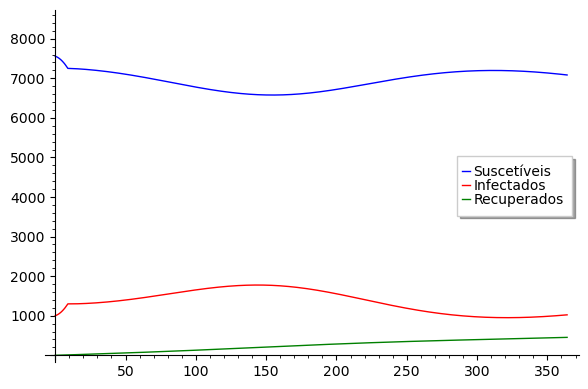

In [20]:
def run_simulation(num_steps = 365,
dt = 1,
t_initial = 0,
t_final = num_steps * dt,

T1=27.4,
T2=0.025,
omega1=0.02,
phi1=1.53,

R1=196.9,
R2=0.033,
omega2=0.025,
phi2=1.99,

B_E=200,
p_ME=0.9,
p_ML=0.25,
p_MP=0.75,
tau_E=1,
tau_P=1,
c1=0.00554,
c2=-0.06737,
D1=36.5,
b1=0.1,
A=-0.03,
B=1.31,
C=-4.4,
b2=0.3,
tau_H=10,
DD=105,
Tmin=14.5,
gamma= 1/1095, #1/365
R_L = 50,
N=8558,
M= 300000, #100000
I_M0=50000, # None
I_H0=1000):
    
    # Definindo as constantes
    if I_M0 is None:
        I_M0 = M / 100

    S_H0 = N - I_H0

    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*(Temp)**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_E(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_P(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)

    # Definindo a função de sobrevivência do mosquito
    def l(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))

    # Simulando as equações diferenciais
    S_H = [S_H0]
    I_H = [I_H0]
    R_H = [0]
    times = [0]

    for t in range(1, num_steps):
        # Atualiza a temperatura e a chuva
        T_curr = Temp(t * dt)
        R_curr = Rain(t * dt)

        # Calcular a taxa de mordida e probabilidade de transmissão
        a = (T_curr - T1) / D1
        #b = B_E * p_ME * p_LRT(R_curr,T_curr) * p_MP / (tau_E + tau_L(T_curr) + tau_P)
        
        b = B_E * p_E(R_curr) * p_LRT(R_curr,T_curr) * p_P(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
        #print(b)
        
        if t < tau_H:
            dS_H = -a * b2 * (I_M0 / N) * S_H[-1]
            dI_H = a * b2 * (I_M0 / N) * S_H[-1] - gamma * I_H[-1]
        else:
            dS_H = -a * b2 * (I_H[t - tau_H] / N) * S_H[t - tau_H]
            dI_H = a * b2 * (I_H[t - tau_H] / N) * S_H[t - tau_H] - gamma * I_H[-1]
        dR_H = gamma * I_H[-1]

        # Atualize as populações
        S_H.append(S_H[-1] + dt * dS_H)
        I_H.append(I_H[-1] + dt * dI_H)
        R_H.append(R_H[-1] + dt * dR_H)
        times.append(t * dt)

    # Calculando R_0
    def calculate_R0(M, a, b1, b2, Temp, gamma, N): # , mu)
        tau_M_T = tau_M(Temp)
        l_tau_M = l(tau_M_T, Temp)  
        R_0 = (M * a**2 * b1 * b2 * l_tau_M) / (gamma * mu(Temp) * N)
        return R_0

    R_0 = calculate_R0(M, a, b1, b2, T1, gamma, N)  # , mu)
    print(f"R_0: {R_0}")

    # Calcular prevalências de equilíbrio
    I_M_star = M * (R_0 - 1) / ((R_0 / l(DD / (T1 - Tmin), T1)) + (a * b2 * M / (gamma * N)))
    I_H_star = N * (R_0 - 1) / (R_0 + (a * b1 / mu(T1)))

    print(f"Prevalência de equilíbrio para mosquitos: {I_M_star}")
    print(f"Prevalência de equilíbrio para humanos: {I_H_star}")

    times = [i*dt for i in range(num_steps)]

    # Criar os gráficos
    p1 = line(zip(times, S_H), color='blue', legend_label='Suscetíveis')
    p2 = line(zip(times, I_H), color='red', legend_label='Infectados')
    p3 = line(zip(times, R_H), color='green', legend_label='Recuperados')

    # Combinar os gráficos e mostrar o resultado
    (p1 + p2 + p3).show(xmin=0, xmax=num_steps*dt, ymin=0, ymax=N)

# Executar a simulação com os parâmetros padrão
run_simulation()